爆大量，超平台，當天上漲

第二步：

爆大量後回檔，超平台，當天上漲

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
stock = "8996.TW"
data = yf.download(stock, start='2023-01-01')

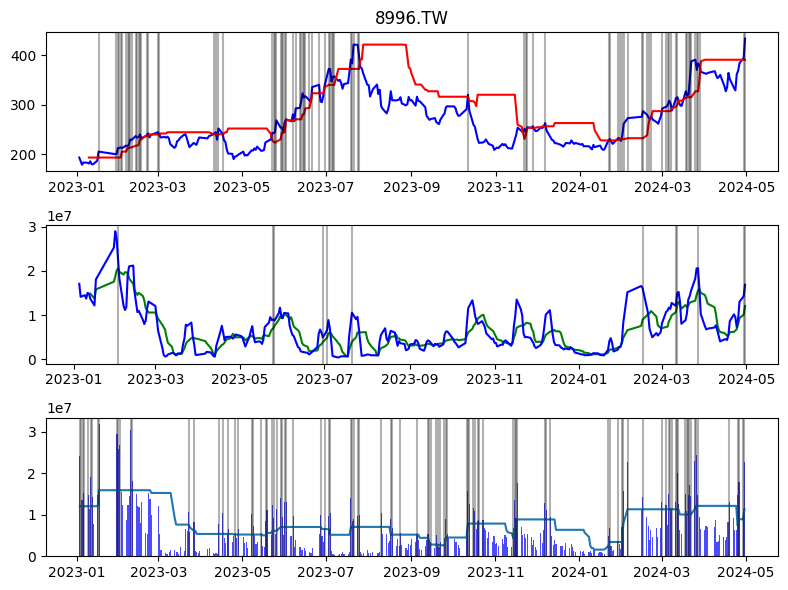

In [6]:
# 爆大量，超平台，當天上漲
# 怎麼停損
data['V5'] = data['Volume'].rolling(9).mean()
data['V3'] = data['Volume'].rolling(3).mean()
data['V3o5'] =  data['V3'] > data['V5']
data['returnOnClose'] = data['Close'].pct_change()
# def: 連續五天v3 > v5

# print(consecutive_false_indices)
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
ax[0].plot(data['Close'], color='blue', label='Close Price')
# ax[1].plot(data['Volume'], color='red', label='Volume')
ax[1].plot(data['V5'], color='green', label='avg20vol')
ax[1].plot(data['V3'], color='blue', label='avg20vol')



# huge volume

# break the correction stage
data['price_max20'] = data['Close'].rolling(window=20, min_periods=1).max()
data['price_max20_late5'] = data['price_max20'].shift(5)

data['signal_price'] = data['price_max20_late5'] < data['Close']
data['signal_vol'] = data['V3o5'].rolling(window=5, min_periods=1).apply(lambda x: all(x == True))
data['signal_return'] = data['returnOnClose'] > 0

data['signal_total'] = (data['signal_price'] == True) & (data['signal_vol'] == True) & (data["signal_return"] == True)
# =========== signal_price step2
# 要再加一個 break前要有至少20天沉寂的交易量．
data['max_vol_20_half'] = data['Volume'].rolling(window=20, min_periods=1).max()*0.5
data['signal_vol_half_max'] = data['Volume'] > data['max_vol_20_half']
ax[2].plot(data['max_vol_20_half'])
# data['signal_price_s2'] 
for dates in data[data['signal_vol_half_max'] == 1].index:
    ax[2].axvline(dates, color='black', alpha=0.3)

ax[0].plot(data['price_max20_late5'], color="r", label='max_plate')
for dates in data[data['signal_price'] == 1].index:
    ax[0].axvline(dates, color='black', alpha=0.3)

for dates in data[data['signal_total'] == 1].index:
    ax[1].axvline(dates, color='black', alpha=0.3)

volume = data['Volume']
ax[2].bar(volume.index, volume, color='blue', alpha=0.7)
ax[0].set_title(stock)
plt.tight_layout()
plt.show()


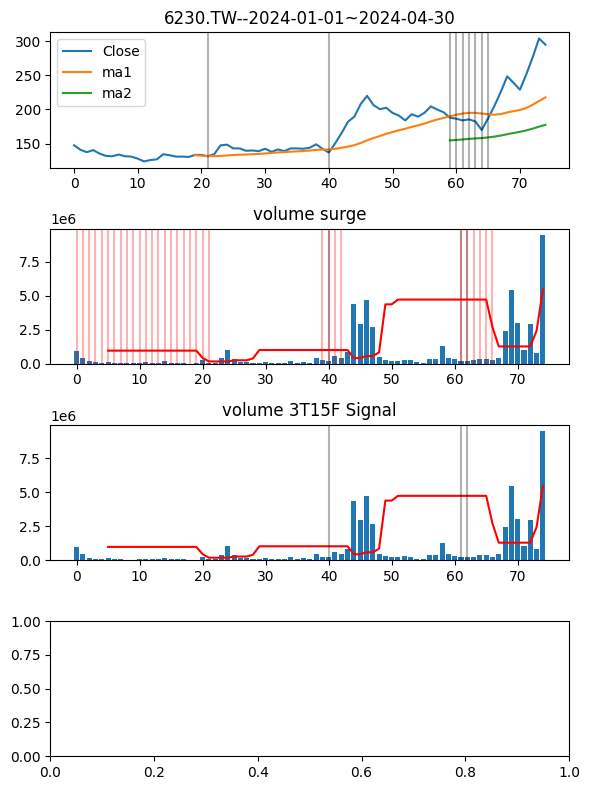

In [66]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(4, 1, figsize=(6, 8))
start = '2024-01-01'
end = "2024-04-30"
stock = "6230.TW"
price_ma1 = 20
price_ma2 = 60
df = yf.download(stock, start=start, end=end, interval='1d', progress=0)
df['day_count'] = np.arange(0, len(df))

"""Columns
day_count, [default]
price_max20, price_ma20, price_ma60, price_ma20_low, price_ma60_low
vol_max20, vol_max20_shift5
"""

df['price_max20'] = df['Close'].rolling(window=20, min_periods=1).max()
df[f'price_ma{price_ma1}'] = df['Close'].rolling(window=price_ma1).mean()
df[f'price_ma{price_ma2}'] = df['Close'].rolling(window=price_ma2).mean()
df[f'price_ma{price_ma1}_low'] = df['Close'] < df[f"price_ma{price_ma1}"]
df[f'price_ma{price_ma2}_low'] = df['Close'] < df[f"price_ma{price_ma2}"]

# detact volume surge
df['vol_max20'] = df['Volume'].rolling(window=15, min_periods=1).max()
df['vol_max20_shift5'] = df['vol_max20'].shift(5)
df['vol_max20_shift5_over'] = df['Volume'] > df['vol_max20_shift5']
# detact volume correction
# 三天爆大量，接下來15/20天未爆大量
df['vol_step1'] = df['vol_max20_shift5_over'].rolling(window=3, min_periods=1).apply(lambda x: all(x == True))
df['vol_step1'] = df['vol_step1'].shift(15)
df['vol_step2'] = df['vol_max20_shift5_over'].rolling(window=15, min_periods=1).apply(lambda x: all(x == False)).shift(-1)
df['vol_3T15F'] = (df['vol_step1'] == True) & (df['vol_step2'] == True)

ax[2].bar(df['day_count'], df['Volume'])
ax[2].plot(df['day_count'], df['vol_max20_shift5'], color='r')

for dates in df[df["vol_3T15F"] == 1]['day_count']:
    ax[2].axvline(dates, color='black', alpha=0.3)
# ==================================================================

ax[0].set_title(f"{stock}--{start}~{end}")
ax[0].plot(df['day_count'], df['Close'], label='Close')
ax[0].plot(df['day_count'], df[f'price_ma{price_ma1}'], label='ma1')
ax[0].plot(df['day_count'], df[f'price_ma{price_ma2}'], label='ma2')

for dates in df[df[f'price_ma{price_ma1}_low'] == 1]['day_count']:
    ax[0].axvline(dates, color='black', alpha=0.3)

for dates in df[df['vol_step1'] == 1]['day_count']:
    ax[1].axvline(dates, color='black', alpha=0.3)
for dates in df[df['vol_step2'] == 1]['day_count']:
    ax[1].axvline(dates, color='red', alpha=0.3)


ax[0].legend()

ax[1].bar(df['day_count'], df['Volume'])
ax[1].plot(df['day_count'], df['vol_max20_shift5'], color='r')


df['returns'] = df['Close'].pct_change()
# df['returns_0'] = df['returns'] > 0 
# df['signal_vol_return'] = (df['vol_max20_shift5_over'] == True) & (df['returns_0'])
# ax[2].bar(df['day_count'], df['Volume'])
# for dates in df[df['signal_vol_return'] == 1]['day_count']:
#     ax[2].axvline(dates, color='green', alpha=0.3)

ax[1].set_title("volume surge")
ax[2].set_title("volume 3T15F Signal")

plt.tight_layout()

In [68]:
# backtest
# required: dt as index, close price, signal = 1;0, signal_close as close_signal(1; 0)
df_bt = df[['vol_3T15F', 'Close']]
df_bt[df['vol_3T15F'] == True].index

DatetimeIndex(['2024-03-08', '2024-04-10', '2024-04-11'], dtype='datetime64[ns]', name='Date', freq=None)